In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from pathlib import Path

# Helper functions
from helper_functions import get_images, prep_for_train

# Styles for miles
style.use('ggplot')

In [2]:
model_deepfake = keras.Sequential([
  layers.Conv2D(filters = 64, kernel_size = 4, strides = (1, 1), input_shape = (256, 256, 3), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters = 32, kernel_size = 4, strides = (1, 1), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters = 16, kernel_size = 4, strides = (1, 1), padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(units = 4096, activation = 'relu'),
  layers.Dropout(rate = 0.1),
  layers.Dense(units = 256, activation = 'relu'), 
  layers.Dense(units = 1)
])

In [3]:
model_deepfake.compile(optimizer = SGD(lr=0.001), 
                       metrics = keras.metrics.BinaryAccuracy(),
                       loss = keras.losses.BinaryCrossentropy())

In [4]:
model_deepfake.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      3136      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      32800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        8208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

In [5]:
# TRAIN THAT MODEL!
X, y = prep_for_train(get_images(1000, seed=430))
model_fit = model_deepfake.fit(X, y, epochs=10, batch_size=50, validation_data=prep_for_train(get_images(100, dtype='valid', seed=430)))

Epoch 1/10
20/20 [==============================] - 41s 2s/step - loss: 1.6799 - binary_accuracy: 0.4957 - val_loss: 0.6959 - val_binary_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 39s 2s/step - loss: 0.7132 - binary_accuracy: 0.5108 - val_loss: 0.6891 - val_binary_accuracy: 0.5100
Epoch 3/10
20/20 [==============================] - 38s 2s/step - loss: 0.7008 - binary_accuracy: 0.5453 - val_loss: 0.6909 - val_binary_accuracy: 0.5300
Epoch 4/10
20/20 [==============================] - 37s 2s/step - loss: 0.6927 - binary_accuracy: 0.5653 - val_loss: 0.6788 - val_binary_accuracy: 0.5800
Epoch 5/10
20/20 [==============================] - 37s 2s/step - loss: 0.6828 - binary_accuracy: 0.5553 - val_loss: 0.6748 - val_binary_accuracy: 0.6000
Epoch 6/10
20/20 [==============================] - 37s 2s/step - loss: 0.6906 - binary_accuracy: 0.5379 - val_loss: 0.7014 - val_binary_accuracy: 0.5200
Epoch 7/10
20/20 [==============================] - 38s 2s/step - loss: 0.66

In [40]:
model_fit.history

{'loss': [4.752274990081787,
  6.557172775268555,
  6.557172775268555,
  6.557172775268555,
  6.557172775268555],
 'binary_accuracy': [0.550000011920929,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426,
  0.5699999928474426],
 'val_loss': [7.319634437561035,
  7.319634437561035,
  7.319634437561035,
  7.319634437561035,
  7.319634437561035],
 'val_binary_accuracy': [0.5199999809265137,
  0.5199999809265137,
  0.5199999809265137,
  0.5199999809265137,
  0.5199999809265137]}

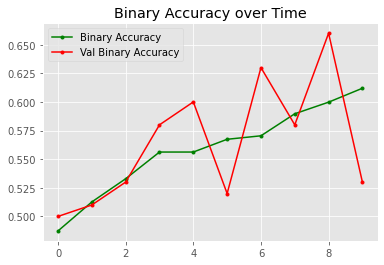

In [10]:
plt.plot(model_fit.history['binary_accuracy'], 'g.-', label = 'Binary Accuracy')
plt.plot(model_fit.history['val_binary_accuracy'], 'r.-', label = 'Val Binary Accuracy')
plt.legend()
plt.title('Binary Accuracy over Time')
plt.show()

In [20]:
model1 = model_fit

In [10]:
print(tf.__version__)

2.4.1


In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12550747937090227957
]


In [8]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
|